In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from DataCTR import DataCTR

%matplotlib inline

### データの読み込み

In [46]:
train_df = pd.read_csv(r'../data/input/train.csv',)
test_df = pd.read_csv(r'../data/input/test.csv')

In [47]:
train_df.reset_index(drop=True, inplace=True)
train_df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [48]:
# Id列削除前の型を確認
print("The train_df data size before dropping Id feature is : {} ".format(train_df.shape))
print("The test_df data size before dropping Id feature is : {} ".format(test_df.shape))

# Idだけ別に保持する
train_df_ID = train_df['id']
test_df_ID = test_df['id']

# 予測に不要なのでId列を削除する
train_df.drop("id", axis = 1, inplace = True)
test_df.drop("id", axis = 1, inplace = True)

# Id列削除後の型を確認
print("\nThe train_df data size after dropping Id feature is : {} ".format(train_df.shape)) 
print("The test_df data size after dropping Id feature is : {} ".format(test_df.shape))

The train_df data size before dropping Id feature is : (20758, 18) 
The test_df data size before dropping Id feature is : (13840, 17) 

The train_df data size after dropping Id feature is : (20758, 17) 
The test_df data size after dropping Id feature is : (13840, 16) 


### データの調査

In [49]:
#データの要約情報を表示(数値データのみ)
train_df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


In [50]:
#データの要約情報を表示(文字データのみ)
train_df.describe(include="O")

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
count,20758,20758,20758,20758,20758,20758,20758,20758,20758
unique,2,2,2,4,2,2,3,5,7
top,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_III
freq,10422,17014,18982,17529,20513,20071,15066,16687,4046


In [51]:
#object型のデータを取り出す
for column in train_df.select_dtypes(include='object').columns:
    # uniq情報を取得
    uniq = train_df[column].unique()

    # 表示
    print("{:20} unique:{:5} {}".format(
        column,
        len(uniq),
        uniq,  # 多すぎる場合があるので5件に抑える
    ))


Gender               unique:    2 ['Male' 'Female']
family_history_with_overweight unique:    2 ['yes' 'no']
FAVC                 unique:    2 ['yes' 'no']
CAEC                 unique:    4 ['Sometimes' 'Frequently' 'no' 'Always']
SMOKE                unique:    2 ['no' 'yes']
SCC                  unique:    2 ['no' 'yes']
CALC                 unique:    3 ['Sometimes' 'no' 'Frequently']
MTRANS               unique:    5 ['Public_Transportation' 'Automobile' 'Walking' 'Motorbike' 'Bike']
NObeyesdad           unique:    7 ['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']


In [52]:
#number型のデータを取り出す
for column in train_df.select_dtypes(include='number').columns:
    # uniq情報を取得
    uniq = train_df[column].unique()

    # 表示
    print("{:20} unique:{:5} {}".format(
        column,
        len(uniq),
        uniq[:5],  # 多すぎる場合があるので5件に抑える
    ))

Age                  unique: 1703 [24.443011 18.       20.952737 31.641081 18.128249]
Height               unique: 1833 [1.699998 1.56     1.71146  1.71073  1.914186]
Weight               unique: 1979 [ 81.66995   57.        50.165754 131.274851  93.798055]
FCVC                 unique:  934 [2.       1.880534 3.       2.679664 2.919751]
NCP                  unique:  689 [2.983297 3.       1.411685 1.971472 2.164839]
CH2O                 unique: 1506 [2.763573 2.       1.910378 1.674061 1.979848]
FAF                  unique: 1360 [0.       1.       0.866045 1.467863 1.967973]
TUE                  unique: 1297 [0.976473 1.       1.673584 0.780199 0.931721]


NObeyesdad
Obesity_Type_III       0.194913
Obesity_Type_II        0.156470
Normal_Weight          0.148473
Obesity_Type_I         0.140187
Insufficient_Weight    0.121544
Overweight_Level_II    0.121495
Overweight_Level_I     0.116919
Name: proportion, dtype: float64


<Axes: xlabel='NObeyesdad', ylabel='count'>

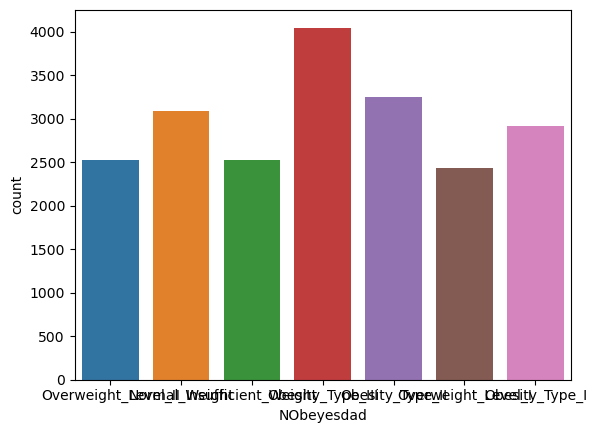

In [53]:
#目的変数(NObeyesdad)の分布を確認
print(train_df['NObeyesdad'].value_counts(normalize=True))
sns.countplot(train_df,x='NObeyesdad')

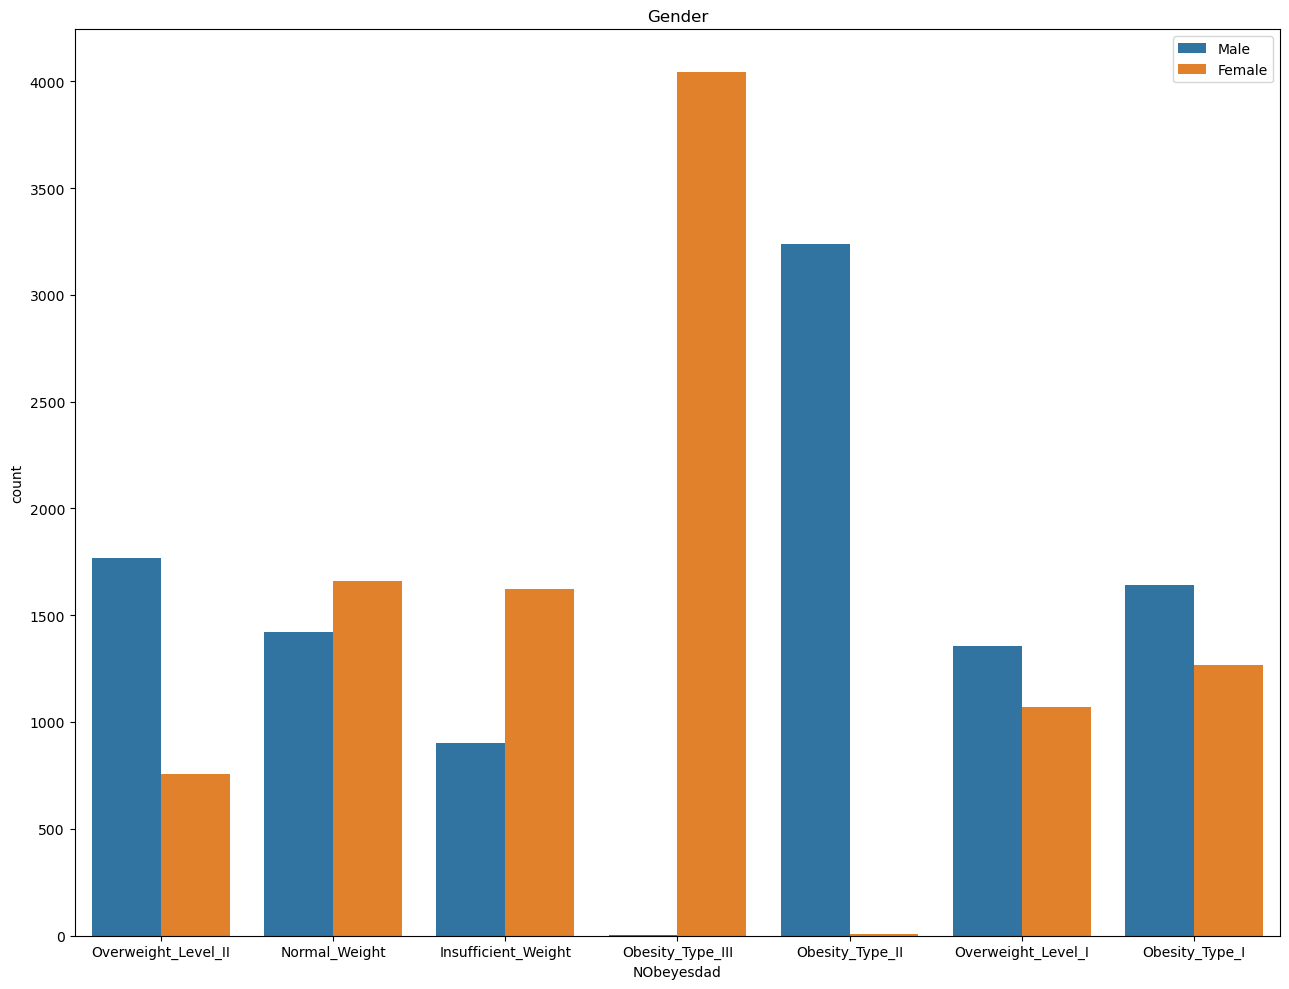

In [54]:
plot_data = DataCTR(train_df)
plot_data.plot_compare_category_category("NObeyesdad","Gender",scale=2)

d:\kaggle\Multi-Class_Prediction_of_Obesity_Risk\exp\DataCTR.py:77: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(self.df[self.df[column1]==uniq][column2], kde=True, rug=False, bins=bins, label=uniq)
c:\Users\kppis\anaconda3\envs\kaggle-pra\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\kaggle\Multi-Class_Prediction_of_Obesity_Risk\exp\DataCTR.py:77: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please

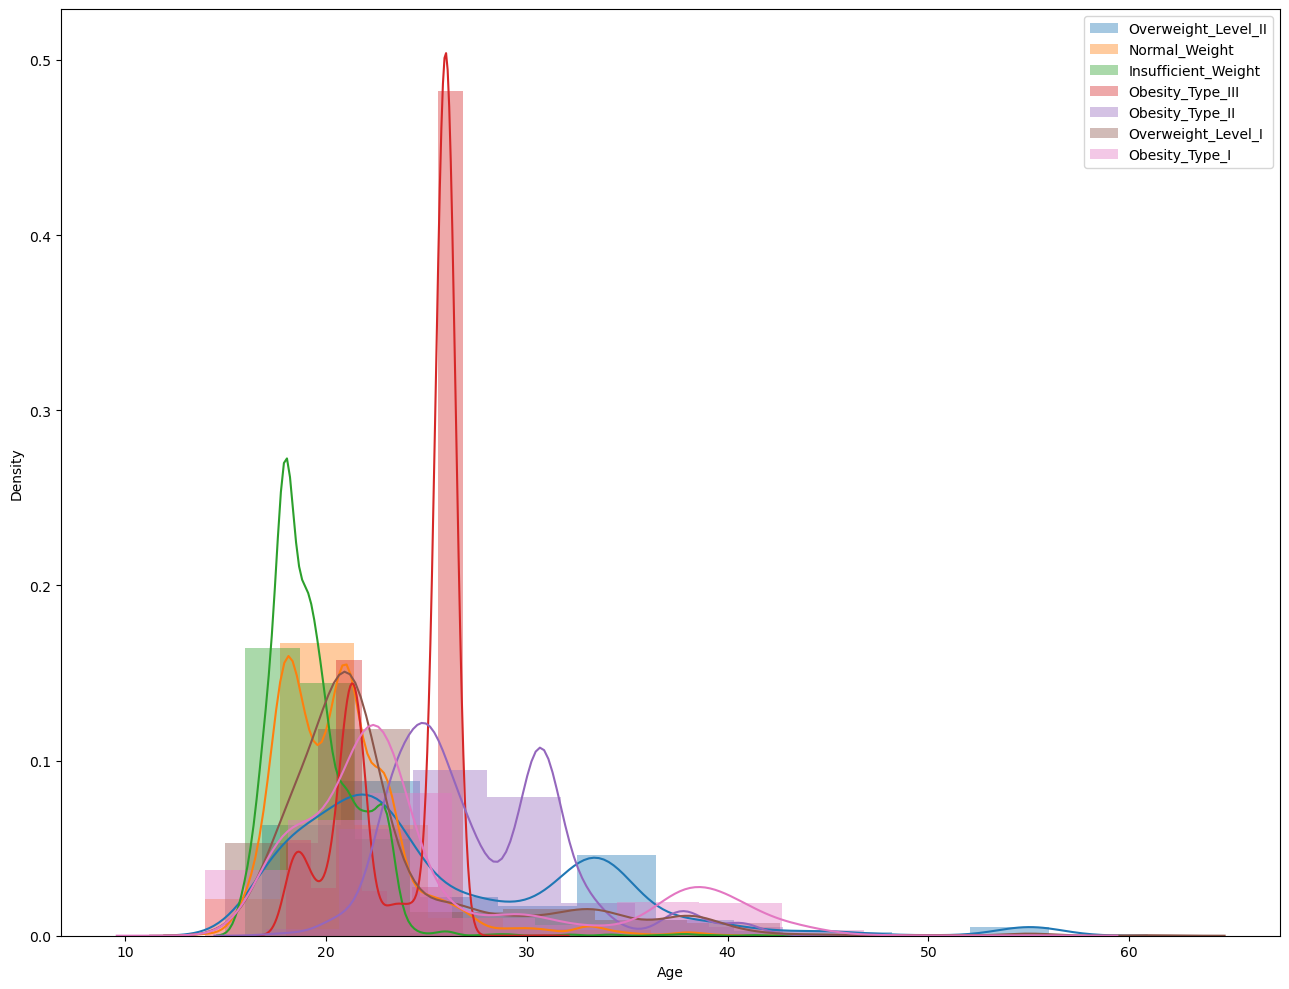

In [55]:
plot_data.plot_compare_category_number("NObeyesdad","Age",scale=2)

# 前処理

In [56]:
# 欠損値の確認
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF                             

In [57]:
train_df = DataCTR(train_df).dummy_category(label_column=["MTRANS"],one_hot_column=["Gender", "family_history_with_overweight", "FAVC", "SMOKE", "SCC"])
train_df = DataCTR(train_df).ordinal_category(column="CAEC",order={"no":0, "Sometimes":1, "Frequently":2, "Always":3})
train_df = DataCTR(train_df).ordinal_category(column="CALC",order={"no":0, "Sometimes":1, "Frequently":2})

In [58]:
train_df.head()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,MTRANS,NObeyesdad,Gender_Male,family_history_with_overweight_yes,FAVC_yes,SMOKE_yes,SCC_yes
0,24.443011,1.699998,81.669950,2.000000,2.983297,1,2.763573,0.000000,0.976473,1,3,Overweight_Level_II,True,True,True,False,False
1,18.000000,1.560000,57.000000,2.000000,3.000000,2,2.000000,1.000000,1.000000,0,0,Normal_Weight,False,True,True,False,False
2,18.000000,1.711460,50.165754,1.880534,1.411685,1,1.910378,0.866045,1.673584,0,3,Insufficient_Weight,False,True,True,False,False
3,20.952737,1.710730,131.274851,3.000000,3.000000,1,1.674061,1.467863,0.780199,1,3,Obesity_Type_III,False,True,True,False,False
4,31.641081,1.914186,93.798055,2.679664,1.971472,1,1.979848,1.967973,0.931721,1,3,Overweight_Level_II,True,True,True,False,False


In [59]:
#目的変数NObeyesdadのエンコード
train_df = DataCTR(train_df).ordinal_category(column="NObeyesdad",order={"Insufficient_Weight":0, "Normal_Weight":1, "Overweight_Level_I":2, "Overweight_Level_II":3, "Obesity_Type_I":4, "Obesity_Type_II":5, "Obesity_Type_III":6})

In [60]:
# BMIという特徴量を追加
bmi_list = [bmi for bmi in train_df["Weight"]/(train_df["Height"]*train_df["Height"])]
train_df = DataCTR(train_df).add_feature(column="BMI",data=bmi_list)

In [61]:
train_df.head()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,MTRANS,NObeyesdad,Gender_Male,family_history_with_overweight_yes,FAVC_yes,SMOKE_yes,SCC_yes,BMI
0,24.443011,1.699998,81.669950,2.000000,2.983297,1,2.763573,0.000000,0.976473,1,3,3,True,True,True,False,False,28.259565
1,18.000000,1.560000,57.000000,2.000000,3.000000,2,2.000000,1.000000,1.000000,0,0,1,False,True,True,False,False,23.422091
2,18.000000,1.711460,50.165754,1.880534,1.411685,1,1.910378,0.866045,1.673584,0,3,0,False,True,True,False,False,17.126706
3,20.952737,1.710730,131.274851,3.000000,3.000000,1,1.674061,1.467863,0.780199,1,3,6,False,True,True,False,False,44.855798
4,31.641081,1.914186,93.798055,2.679664,1.971472,1,1.979848,1.967973,0.931721,1,3,3,True,True,True,False,False,25.599151


In [62]:
import sklearn.ensemble
import sklearn.gaussian_process
import sklearn.naive_bayes
import sklearn.linear_model
import sklearn.neighbors
import sklearn.tree
import sklearn.discriminant_analysis
import xgboost as xgb

def create_models(random_seed):
    models = [
        # #Ensemble Methods
        # sklearn.ensemble.AdaBoostClassifier(random_state=random_seed),
        # sklearn.ensemble.BaggingClassifier(random_state=random_seed),
        # sklearn.ensemble.ExtraTreesClassifier(random_state=random_seed),
        # sklearn.ensemble.GradientBoostingClassifier(random_state=random_seed),
        # sklearn.ensemble.RandomForestClassifier(random_state=random_seed),

        # #Gaussian Processes
        # sklearn.gaussian_process.GaussianProcessClassifier(random_state=random_seed),

        # #GLM
        # sklearn.linear_model.LogisticRegressionCV(random_state=random_seed),
        # sklearn.linear_model.RidgeClassifierCV(),

        # #Navies Bayes
        # sklearn.naive_bayes.BernoulliNB(),
        # sklearn.naive_bayes.GaussianNB(),

        # #Nearest Neighbor
        # sklearn.neighbors.KNeighborsClassifier(),

        # #Trees
        # sklearn.tree.DecisionTreeClassifier(random_state=random_seed),
        # sklearn.tree.ExtraTreeClassifier(random_state=random_seed),

        # #Discriminant Analysis
        # sklearn.discriminant_analysis.LinearDiscriminantAnalysis(),
        # sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis(),

        #xgboost
        xgb.XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=random_seed,device = "cuda"),

        # # light bgm
        # lgb.LGBMClassifier(random_state=random_seed),
    ]
    return models

In [63]:
import tqdm
def fit(df, columns, target_column, random_seed):
    # 教師データを作成
    x = df[columns].to_numpy()
    y = df[target_column].to_numpy()


    # 交差検証
    model_scores = {}
    kf = sklearn.model_selection.KFold(n_splits=3, shuffle=True, random_state=random_seed)
    for train_idx, true_idx in kf.split(x, y):
        # 各学習データとテストデータ
        x_train = x[train_idx]
        y_train = y[train_idx]
        x_true = x[true_idx]
        y_true = y[true_idx]

        # 各モデル毎に学習
        for model in create_models(random_seed):
            name = model.__class__.__name__
            if name not in model_scores:
                model_scores[name] = []

            # モデルの学習と評価
            model.fit(x_train, y_train)
            pred_y = model.predict(x_true)

            # 結果を評価
            model_scores[name].append((
                sklearn.metrics.accuracy_score(y_true, pred_y),
                sklearn.metrics.precision_score(y_true, pred_y, average='macro'),
                sklearn.metrics.recall_score(y_true, pred_y, average='macro'),
                sklearn.metrics.f1_score(y_true, pred_y, average='macro'),
            ))

    accs = []
    for k, scores in model_scores.items():
        scores = np.mean(scores, axis=0)



        # モデル毎の平均
        print("正解率 {:.3f}, 適合率 {:.3f}, 再現率 {:.3f}, F値 {:.3f} : {}".format(
            scores[0],
            scores[1],
            scores[2],
            scores[3],
            k,
        ))
        accs.append(scores)

    # 全モデルの中央値
    accs = np.median(accs, axis=0)  # 中央値
    print("正解率 {:.3f}, 適合率 {:.3f}, 再現率 {:.3f}, F値 {:.3f}".format(accs[0], accs[1], accs[2], accs[3]))

#NObeyesdad以外の列名を取得
selected_columns = train_df.columns[train_df.columns != "NObeyesdad"]

selected_columns=list(selected_columns)
fit(train_df, selected_columns, "NObeyesdad", 0)

正解率 0.902, 適合率 0.891, 再現率 0.891, F値 0.891 : XGBClassifier
正解率 0.902, 適合率 0.891, 再現率 0.891, F値 0.891


In [64]:
test_df = DataCTR(test_df).dummy_category(label_column=["MTRANS"],one_hot_column=["Gender", "family_history_with_overweight", "FAVC", "SMOKE", "SCC"])
test_df = DataCTR(test_df).ordinal_category(column="CAEC",order={"no":0, "Sometimes":1, "Frequently":2, "Always":3})
test_df = DataCTR(test_df).ordinal_category(column="CALC",order={"no":0, "Sometimes":1, "Frequently":2, "Always":3})
bmi_list = [bmi for bmi in test_df["Weight"]/(test_df["Height"]*test_df["Height"])]
test_df = DataCTR(test_df).add_feature(column="BMI",data=bmi_list)

In [65]:
#testデータにobjectが残っていないか確認
for column in test_df.select_dtypes(include='object').columns:
    # uniq情報を取得
    uniq = test_df[column].unique()

    # 表示
    print("{:20} unique:{:5} {}".format(
        column,
        len(uniq),
        uniq,  # 多すぎる場合があるので5件に抑える
    ))

In [66]:
x=train_df[selected_columns].to_numpy()
y=train_df["NObeyesdad"].to_numpy()


model=xgb.XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=0,device = "cuda")
model.fit(x,y)
pred_y = model.predict(test_df[selected_columns].to_numpy())

# 追加した特徴量を削除
train_df.drop("BMI", axis = 1, inplace = True)

# 提出用ファイルの作成
submit_df = pd.DataFrame({'id': test_df_ID, 'NObeyesdad': pred_y})
#NObeyesdadのエンコードを元に戻す
submit_df = DataCTR(submit_df).ordinal_category(column="NObeyesdad",order={"Insufficient_Weight":0, "Normal_Weight":1, "Overweight_Level_I":2, "Overweight_Level_II":3, "Obesity_Type_I":4, "Obesity_Type_II":5, "Obesity_Type_III":6},reverse=True)
submit_df.to_csv('submission.csv', index=False)